# Data Exploration


## Import Libraries

In [45]:
import sys
import os
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
	sys.path.append(module_path)

import src.utils
importlib.reload(src.utils)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils import create_id_champ_map, get_unique_champs_from_df, get_win_counts, RANK_COLORS, RANK_ORDER
from numpy.typing import ArrayLike
from pandas import DataFrame


## Utils

In [46]:
champ_id_map = create_id_champ_map(reverse_map=True)
id_champ_map = create_id_champ_map()

champ_id_map.pop("No Champion")
id_champ_map.pop(0)

print("Printing the first 5 keys in each map.")
print({ id: id_champ_map[id] for id in range(1, 6) })

Printing the first 5 keys in each map.
{1: 'Annie', 2: 'Olaf', 3: 'Galio', 4: 'TwistedFate', 5: 'XinZhao'}


## Dataset Overview

In [47]:
matches = pd.read_csv("../data/TeamMatchTbl.csv")
matches.head()

,TeamID,MatchFk,B1Champ,B2Champ,B3Champ,B4Champ,B5Champ,R1Champ,R2Champ,R3Champ,...,BlueDragonKills,BlueTowerKills,BlueKills,RedBaronKills,RedRiftHeraldKills,RedDragonKills,RedTowerKills,RedKills,RedWin,BlueWin
0,1,EUW1_7565751492,897,154,157,51,902,164,5,25,...,1,3,13,1,0,3,8,26,1,0
1,2,EUW1_7565549583,82,238,157,236,89,6,254,127,...,3,10,39,0,1,1,3,33,0,1
2,3,EUW1_7564803077,516,28,4,498,235,23,64,38,...,2,7,27,2,0,3,8,37,1,0
3,4,EUW1_7564368646,54,34,59,498,103,61,25,55,...,0,4,55,0,0,0,0,39,0,1
4,5,EUW1_7564332041,12,800,111,150,142,141,101,55,...,0,0,42,0,0,0,0,0,0,1


In [48]:
blue_champ_cols = ["B1Champ", "B2Champ", "B3Champ", "B4Champ", "B5Champ"]
red_champ_cols = ["R1Champ", "R2Champ", "R3Champ", "R4Champ", "R5Champ"]
targets = ["RedWin", "BlueWin"]
relevant_features = blue_champ_cols + red_champ_cols

print("=" * 50)
print("Preliminary Dataset Info")
print("=" * 50)

print("Shape: " + str(matches.shape))
print()

print("Pre-match features: " + str(len(relevant_features)))
print(relevant_features)
print()

# We drop these because we're trying to predict the outcome using only pre-match information (champ picks).
print("Post-match features: " + str(matches.drop(columns=relevant_features + targets).shape[1]) + " (To be dropped)")
print([col for col in matches.columns if col not in relevant_features + targets])

print()

missing_values = matches[relevant_features].isnull().sum()
num_duplicated = matches.duplicated().sum()
num_unique_champs = len(get_unique_champs_from_df(matches, relevant_features))

print("Missing rows: " + str(missing_values.sum()))
print("Duplicated rows: " + str(num_duplicated))
print("Unique Champions: " + str(len(set(id_champ_map))))
print()

if num_unique_champs != len(set(id_champ_map)):
	print("❌ Mismatch between unique champs in champion map and dataset")
else:
	print("✅ The number of unique champions in the dataset matches the amount in the game.")

matches.dropna(subset=relevant_features, inplace=True)
matches.drop_duplicates(inplace=True)

Preliminary Dataset Info
Shape: (135184, 24)

Pre-match features: 10
['B1Champ', 'B2Champ', 'B3Champ', 'B4Champ', 'B5Champ', 'R1Champ', 'R2Champ', 'R3Champ', 'R4Champ', 'R5Champ']

Post-match features: 12 (To be dropped)
['TeamID', 'MatchFk', 'BlueBaronKills', 'BlueRiftHeraldKills', 'BlueDragonKills', 'BlueTowerKills', 'BlueKills', 'RedBaronKills', 'RedRiftHeraldKills', 'RedDragonKills', 'RedTowerKills', 'RedKills']

Missing rows: 0
Duplicated rows: 0
Unique Champions: 172

✅ The number of unique champions in the dataset matches the amount in the game.


## Dataset Analysis


### Team Winrates

The dataset has class imbalance towards blue side. This is known as *blue-side advantage* in the league community. The results show that the blue team wins 11.4% more often than the red team which would make this dataset a pretty extreme case of this phenomenon. Even though there's class imbalance, this shouldn't be a problem. Here's why:

- There are a decent number of examples of both outcomes in the dataset. Class imbalance becomes problematic when there are extreme ratios, like 90-10 or 95-5. At this level it shouldn't affect the model's ability to learn patterns.
- Even if the model becomes slightly biased towards blue side, **that's how it actually is in league**. We wouldn't expect it to be unbiased.

Red Team Wins: 59930
Blue Team Wins: 75254


[]

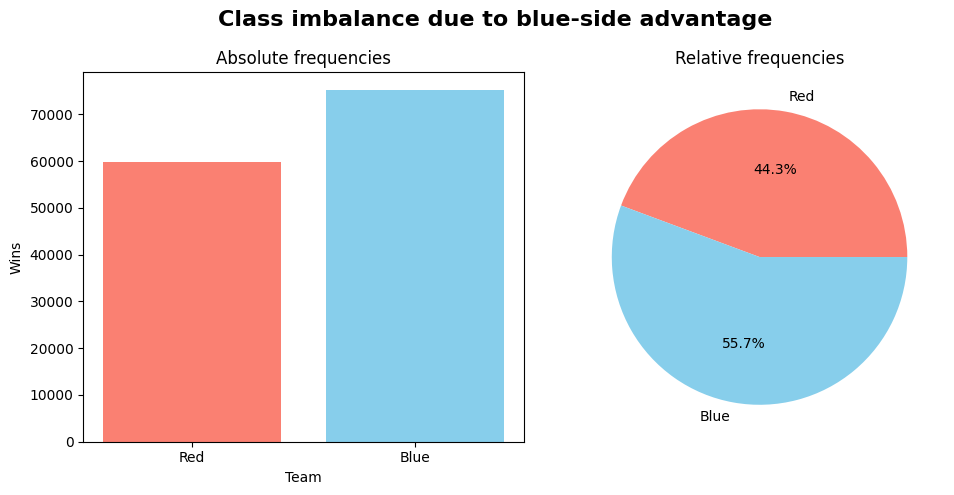

In [49]:

wins = matches[targets]
red_team_wins, blue_team_wins = get_win_counts(wins, targets)

print(f"Red Team Wins: {red_team_wins}")
print(f"Blue Team Wins: {blue_team_wins}")

colors = ['salmon', 'skyblue']
teams = ["Red", "Blue"]
team_wins = [red_team_wins, blue_team_wins]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Class imbalance due to blue-side advantage", fontsize=16, fontweight="bold")

ax[0].bar(teams, team_wins, color=colors)
ax[0].set_title("Absolute frequencies")
ax[0].set_xlabel("Team")
ax[0].set_ylabel("Wins")

ax[1].pie(team_wins, labels=teams, colors=colors, autopct='%1.1f%%')
ax[1].set_title("Relative frequencies")

plt.tight_layout()
plt.plot()

### Elo Distribution

Because the blue-side advantage is so strong, I'm curious what the elo distribution is in this dataset. I would expect the games to be more skewed towards high-elo, as high-elo players are more capable of making use of small advantages. Here are some observations:

- Iron, Bronze, Silver, and Gold matches make up less than 31% of all total games. 
- Challenger and Grandmaster matches make up less than 2% of all total games.
- The vast majority of matches are played in Gold, Platinum, Emerald, Diamond, and Master, with frequencies for the first 4 being roughly equal.
- There are a disproportionate amount of games played in Master elo.



In [50]:
match_metadata_df = pd.read_csv("../data/MatchTbl.csv")
ranks_df = pd.read_csv("../data/RankTbl.csv")

match_metadata_merged_df = pd.merge(
	match_metadata_df, 
	ranks_df, 
	left_on="RankFk", 
	right_on="RankId"
)

match_metadata_merged_df = match_metadata_merged_df.drop(columns=["RankFk"])
match_metadata_merged_df.head()

ranks = match_metadata_merged_df["RankName"].unique()
rank_counts_df = match_metadata_merged_df["RankName"].value_counts()

print(f"Ranks: {ranks}")
print(f"Unranked Frequency: {rank_counts_df["Unranked"]}")
print(f"Elo with most games: {rank_counts_df.idxmax()}")
print(f"Elo with fewest games: {rank_counts_df.idxmin()}")
print(f"Top 3 elos with most games: \n{rank_counts_df.nlargest(3)}")
print(f"Top 3 elos with fewest games: \n{rank_counts_df.nsmallest(3)}")

Ranks: ['Unranked' 'Emerald' 'Gold' 'Platinum' 'Bronze' 'Silver' 'Diamond'
 'Master' 'Iron' 'Challenger' 'Grandmaster']
Unranked Frequency: 17613
Elo with most games: Master
Elo with fewest games: Challenger
Top 3 elos with most games: 
RankName
Master      31308
Platinum    22384
Gold        20541
Name: count, dtype: int64
Top 3 elos with fewest games: 
RankName
Challenger      439
Iron           2226
Grandmaster    2358
Name: count, dtype: int64


In [51]:
rank_counts_df = rank_counts_df.reindex(RANK_ORDER)

print("Rank Frequencies")
rank_counts_df

Rank Frequencies


RankName
Iron            2226
Bronze          4755
Silver         12295
Gold           20541
Platinum       22384
Emerald        18132
Diamond        17812
Master         31308
Grandmaster     2358
Challenger       439
Name: count, dtype: int64

[]

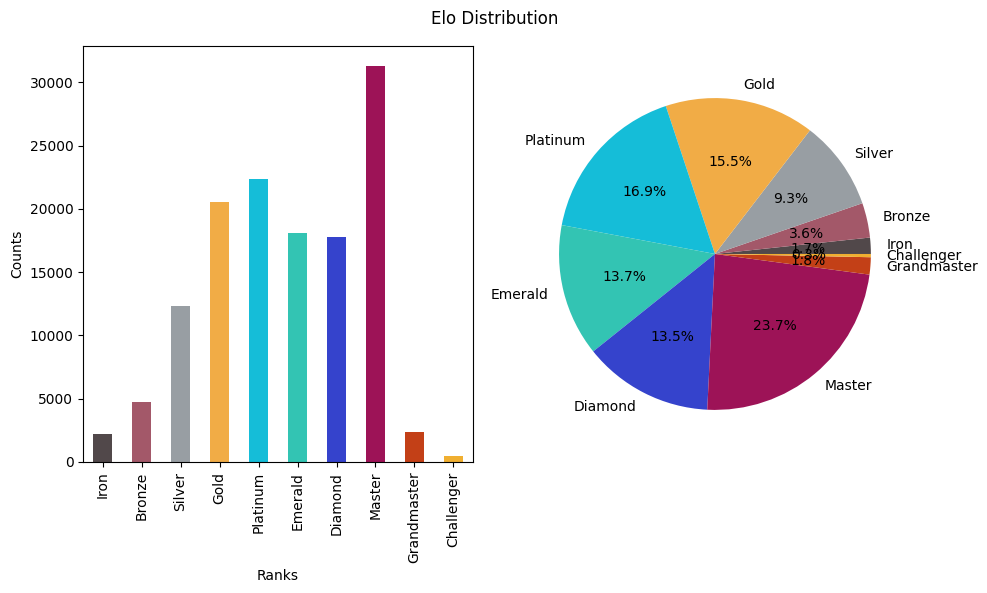

In [62]:
rank_colors = [RANK_COLORS[rank] for rank in RANK_ORDER]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

fig.suptitle("Elo Distribution")

rank_counts_df.plot(kind="bar", xlabel="Ranks", ylabel="Counts", ax=ax[0], color=rank_colors)
rank_counts_df.plot(kind='pie', ylabel="", ax=ax[1], colors=rank_colors, autopct="%1.1f%%")

plt.tight_layout()
plt.plot()

### Champion Analysis

Now let's analyze the champions in the dataset to understand pick rates, popularity, and win rates. This will help us understand which champions are most commonly played and how they perform. Here are the key findings:

**Pick Rate Distribution:**
- All 172 champions appear in the dataset with pick rates ranging from 1.83% (Skarner) to 15.91% (Kai'Sa).
- The mean pick rate is 5.81% and median is 5.24%, indicating a relatively even distribution.
- 12 champions have pick rates above 10%, with the most popular being Kai'Sa, Caitlyn, Miss Fortune, and Sylas.
- No champions fall below 1% pick rate, meaning all champions see meaningful play in the dataset.
- The least picked champions include Skarner, Shyvana, Kalista, Rammus, and Nilah.

**Win Rate Analysis:**
- Champion win rates are fairly balanced, with a mean of 49.96% and median of 49.86%, both close to 50%.
- The win rate spread is relatively narrow, ranging from 44.90% (Azir) to 52.30% (Kog'Maw).
- Top performers (>51.5% win rate): Kog'Maw, Shen, Singed, Bel'Veth, Sona, Morgana, Milio, and Malphite.
- Bottom performers (<48% win rate): Azir, K'Sante, Corki, Qiyana, Akali, Zeri, and Rengar.

**Pick Rate vs Win Rate Relationship:**
- High pick rate does not guarantee high win rate. For example, Kai'Sa has the highest pick rate (15.91%) but only a 49.99% win rate.
- Some popular champions like Miss Fortune (13.80% pick rate) maintain above-average win rates (51.62%).
- Low pick rate specialists like Kog'Maw and Singed show strong win rates, suggesting they may be niche picks that perform well in specific situations.
- The scatter plot reveals no strong correlation between popularity and performance, indicating champion balance is reasonably good across the roster.

In [53]:
all_champion_picks = []

for col in blue_champ_cols + red_champ_cols:
    all_champion_picks.extend(matches[col].tolist())

champion_pick_counts = pd.Series(all_champion_picks).value_counts()

champion_pick_counts.index = champion_pick_counts.index.map(id_champ_map)

print(f"Total champion picks: {len(all_champion_picks)}")
print(f"Unique champions picked: {len(champion_pick_counts)}")
print(f"\nTop 10 most picked champions:")
print(champion_pick_counts.head(10))
print(f"\nTop 10 least picked champions:")
print(champion_pick_counts.tail(10))

Total champion picks: 1351840
Unique champions picked: 172

Top 10 most picked champions:
Kaisa          21514
Caitlyn        19224
MissFortune    18649
Sylas          17535
Jhin           17351
Ashe           16417
Jinx           16339
Smolder        15342
Mel            15057
Nami           14678
Name: count, dtype: int64

Top 10 least picked champions:
Annie      3564
Sejuani    3545
Renata     3369
Kled       3281
Taric      3118
Nilah      2921
Rammus     2913
Kalista    2900
Shyvana    2802
Skarner    2470
Name: count, dtype: int64


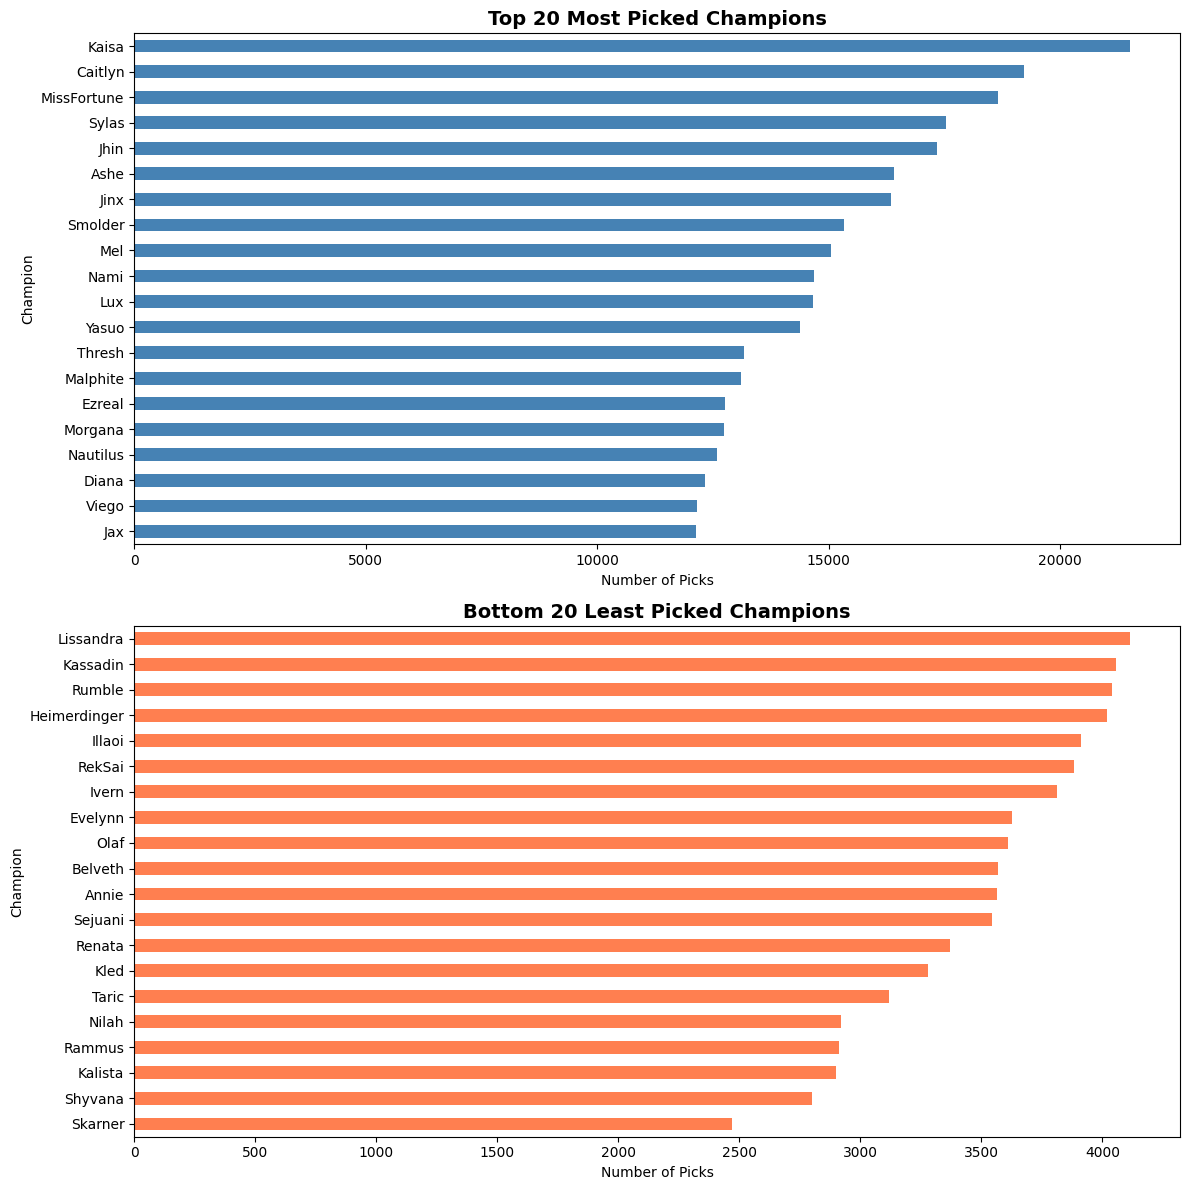

In [54]:
top_20_champions = champion_pick_counts.head(20)
bottom_20_champions = champion_pick_counts.tail(20).sort_values(ascending=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

top_20_champions.plot(kind='barh', ax=ax[0], color='steelblue')
ax[0].set_title('Top 20 Most Picked Champions', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Number of Picks')
ax[0].set_ylabel('Champion')
ax[0].invert_yaxis()

bottom_20_champions.plot(kind='barh', ax=ax[1], color='coral')
ax[1].set_title('Bottom 20 Least Picked Champions', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Number of Picks')
ax[1].set_ylabel('Champion')

plt.tight_layout()
plt.show()

In [55]:
total_games = len(matches)
champion_pick_rate = (champion_pick_counts / total_games) * 100

print("Pick Rate Statistics:")
print(f"Mean pick rate: {champion_pick_rate.mean():.2f}%")
print(f"Median pick rate: {champion_pick_rate.median():.2f}%")
print(f"Max pick rate: {champion_pick_rate.max():.2f}% ({champion_pick_rate.idxmax()})")
print(f"Min pick rate: {champion_pick_rate.min():.2f}% ({champion_pick_rate.idxmin()})")
print(f"\nChampions with >10% pick rate: {len(champion_pick_rate[champion_pick_rate > 10])}")
print(f"Champions with <1% pick rate: {len(champion_pick_rate[champion_pick_rate < 1])}")

Pick Rate Statistics:
Mean pick rate: 5.81%
Median pick rate: 5.24%
Max pick rate: 15.91% (Kaisa)
Min pick rate: 1.83% (Skarner)

Champions with >10% pick rate: 12
Champions with <1% pick rate: 0


In [56]:
def calculate_champion_winrates(df, blue_cols, red_cols, id_map):
    """Calculate win rate for each champion across all games."""
    champion_stats = {}
    
    for col in blue_cols:
        for idx, row in df.iterrows():
            champ_id = row[col]
            win = row['BlueWin']
            
            if champ_id not in champion_stats:
                champion_stats[champ_id] = {'wins': 0, 'games': 0}
            
            champion_stats[champ_id]['games'] += 1
            champion_stats[champ_id]['wins'] += win
    
    for col in red_cols:
        for idx, row in df.iterrows():
            champ_id = row[col]
            win = row['RedWin']
            
            if champ_id not in champion_stats:
                champion_stats[champ_id] = {'wins': 0, 'games': 0}
            
            champion_stats[champ_id]['games'] += 1
            champion_stats[champ_id]['wins'] += win
    
    winrate_data = []
    for champ_id, stats in champion_stats.items():
        winrate = (stats['wins'] / stats['games']) * 100 if stats['games'] > 0 else 0
        winrate_data.append({
            'champion': id_map.get(champ_id, f'Unknown_{champ_id}'),
            'games': stats['games'],
            'wins': stats['wins'],
            'winrate': winrate
        })
    
    return pd.DataFrame(winrate_data).sort_values('winrate', ascending=False)

champion_winrates = calculate_champion_winrates(matches, blue_champ_cols, red_champ_cols, id_champ_map)

print("Champion Win Rate Statistics:")
print(f"Mean win rate: {champion_winrates['winrate'].mean():.2f}%")
print(f"Median win rate: {champion_winrates['winrate'].median():.2f}%")
print(f"\nTop 10 champions by win rate:")
print(champion_winrates.head(10).to_string(index=False))
print(f"\nBottom 10 champions by win rate:")
print(champion_winrates.tail(10).to_string(index=False))

Champion Win Rate Statistics:
Mean win rate: 49.96%
Median win rate: 49.86%

Top 10 champions by win rate:
champion  games  wins   winrate
  KogMaw   4621  2417 52.304696
    Shen   7064  3689 52.222537
  Singed   5326  2774 52.084116
 Belveth   3570  1859 52.072829
    Sona   6185  3220 52.061439
 Morgana  12744  6599 51.781230
   Milio  10591  5480 51.742045
  Zaahen  10515  5440 51.735616
Malphite  13111  6783 51.735184
    Olaf   3609  1866 51.704073

Bottom 10 champions by win rate:
 champion  games  wins   winrate
Gangplank   5190  2499 48.150289
    Yuumi   5562  2678 48.148148
   Yunara  10840  5212 48.081181
   Rengar   7653  3679 48.072651
     Zeri   5205  2500 48.030740
    Akali   9470  4546 48.004224
   Qiyana   8934  4263 47.716588
    Corki   4967  2349 47.292128
   KSante   5686  2642 46.465002
     Azir   4526  2032 44.896156


In [57]:
# Filter champions with significant sample size (at least 100 games) for reliable winrate analysis
min_games_threshold = 100
significant_champions = champion_winrates[champion_winrates['games'] >= min_games_threshold].copy()

print(f"Champions with at least {min_games_threshold} games: {len(significant_champions)} / {len(champion_winrates)}")
print(f"\nTop 15 champions by win rate (min {min_games_threshold} games):")
print(significant_champions.head(15).to_string(index=False))
print(f"\nBottom 15 champions by win rate (min {min_games_threshold} games):")
print(significant_champions.tail(15).to_string(index=False))

Champions with at least 100 games: 172 / 172

Top 15 champions by win rate (min 100 games):
   champion  games  wins   winrate
     KogMaw   4621  2417 52.304696
       Shen   7064  3689 52.222537
     Singed   5326  2774 52.084116
    Belveth   3570  1859 52.072829
       Sona   6185  3220 52.061439
    Morgana  12744  6599 51.781230
      Milio  10591  5480 51.742045
     Zaahen  10515  5440 51.735616
   Malphite  13111  6783 51.735184
       Olaf   3609  1866 51.704073
       Nami  14678  7579 51.635100
MissFortune  18649  9627 51.622071
     RekSai   3882  2001 51.545595
      Brand   8425  4341 51.525223
    Warwick   7223  3719 51.488301

Bottom 15 champions by win rate (min 100 games):
 champion  games  wins   winrate
   Ezreal  12759  6173 48.381535
     Pyke   9257  4472 48.309387
  Ambessa   9956  4806 48.272399
   Akshan   5732  2765 48.237962
  Skarner   2470  1191 48.218623
Gangplank   5190  2499 48.150289
    Yuumi   5562  2678 48.148148
   Yunara  10840  5212 48.081181
 

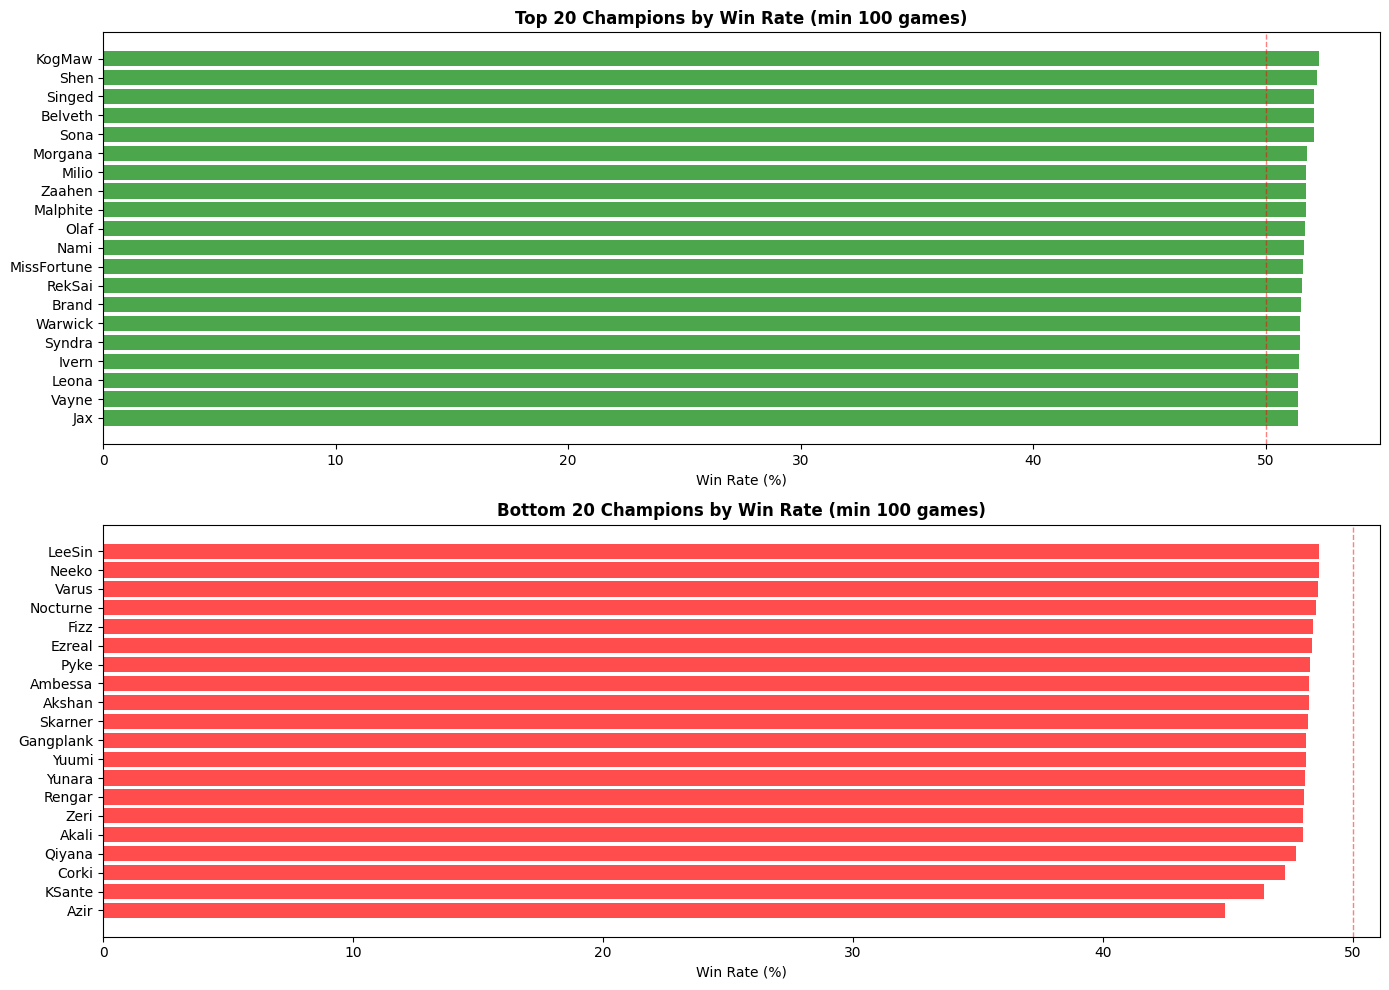

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

top_performers = significant_champions.head(20)
ax[0].barh(range(len(top_performers)), top_performers['winrate'], color='green', alpha=0.7)
ax[0].set_yticks(range(len(top_performers)))
ax[0].set_yticklabels(top_performers['champion'])
ax[0].set_xlabel('Win Rate (%)')
ax[0].set_title(f'Top 20 Champions by Win Rate (min {min_games_threshold} games)', fontweight='bold')
ax[0].invert_yaxis()
ax[0].axvline(x=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

bottom_performers = significant_champions.tail(20).sort_values('winrate', ascending=False)
ax[1].barh(range(len(bottom_performers)), bottom_performers['winrate'], color='red', alpha=0.7)
ax[1].set_yticks(range(len(bottom_performers)))
ax[1].set_yticklabels(bottom_performers['champion'])
ax[1].set_xlabel('Win Rate (%)')
ax[1].set_title(f'Bottom 20 Champions by Win Rate (min {min_games_threshold} games)', fontweight='bold')
ax[1].invert_yaxis()
ax[1].axvline(x=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

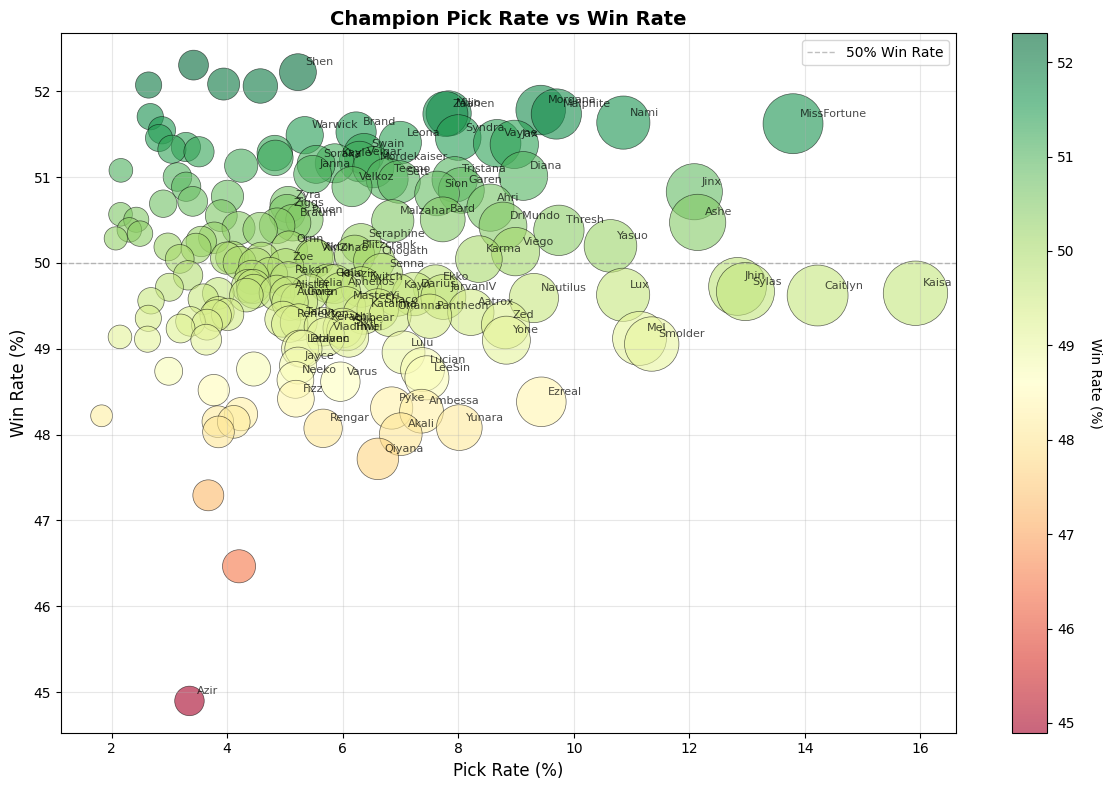

In [59]:
champion_winrates_with_pickrate = champion_winrates.copy()
champion_winrates_with_pickrate['pick_rate'] = (champion_winrates_with_pickrate['games'] / total_games) * 100

fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    champion_winrates_with_pickrate['pick_rate'], 
    champion_winrates_with_pickrate['winrate'],
    alpha=0.6,
    s=champion_winrates_with_pickrate['games'] / 10,
    c=champion_winrates_with_pickrate['winrate'],
    cmap='RdYlGn',
    edgecolors='black',
    linewidth=0.5
)

ax.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% Win Rate')
ax.set_xlabel('Pick Rate (%)', fontsize=12)
ax.set_ylabel('Win Rate (%)', fontsize=12)
ax.set_title('Champion Pick Rate vs Win Rate', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Win Rate (%)', rotation=270, labelpad=20)

interesting_champions = champion_winrates_with_pickrate[
    (champion_winrates_with_pickrate['pick_rate'] > 5) | 
    (champion_winrates_with_pickrate['winrate'] > 54) | 
    (champion_winrates_with_pickrate['winrate'] < 46)
]

for _, row in interesting_champions.iterrows():
    ax.annotate(
        row['champion'], 
        (row['pick_rate'], row['winrate']),
        fontsize=8,
        alpha=0.7,
        xytext=(5, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()